In [1]:
import openmc
import numpy as np
from matplotlib import pyplot as plt

# OpenMC Source Definitions

**This material relates almost entirely to fixed-source problems. For eigenvalue sources, please refer to [this section](https://docs.openmc.org/en/stable/methods/eigenvalue.html) of the OpenMC theory guide.**

OpenMC provides a number of different external source classifications:


- [IndependentSource](https://docs.openmc.org/en/stable/pythonapi/generated/openmc.IndependentSource.html?highlight=sour#openmc-independentsource): a set of independent source distributions in $(\vec{r}, \vec{u}, E, t)$
- [FileSource](https://docs.openmc.org/en/stable/pythonapi/generated/openmc.FileSource.html#openmc-filesource): a set of source particles stored in an HDF5 file or a Monte Carlo particle list ([MCPL](https://mctools.github.io/mcpl/#:~:text=Welcome%20to%20the%20home%20of,various%20Monte%20Carlo%20simulation%20applications.)) file
- [CompiledSource](https://docs.openmc.org/en/stable/pythonapi/generated/openmc.FileSource.html#openmc-filesource): a compiled binary with that complies with a predefined entry point OpenMC uses to source particles from a custom subroutine

all of which can be combined together in a single problem if desired. External sources can be included in a `Settings` object by populating the `Settings.sources` attribute with a list (or other Iterable) of source objects.





## Learning Objectives

- Know the necessary birth characteristics of a
  source particle
- Understand which objects to use for different dimensions of phase space
- Determine how and when to use a mixed
  independent distribution
- Understand how to use the built-in PDF
  functions
- Define a distribution for the source direction
- Use dependent sampling distributions


To source a partile in Monte Carlo, the following must be known:

  - particle type
  - position (x, y, z) or $\vec{r}$
  - angle (u, v, w) or $\vec{u}$
  - energy, E
  - time, t
  - statistical weight, w

# Independent Sources

OpenMC's `IndependentSource` class houses distributions for `space`, `angle`, `energy`, and `time` in a single source object as corresponding attributes of the object. The type of particle source is specified as well.


In [2]:
source = openmc.IndependentSource()
source.space
source.angle

The **`space` and `angle` entries are multivariate** distributions, requiring sampling in multiple dimensions, while the **`energy` and `time` attributes are univariate** distributions, requiring samples in ony one dimension. A variety of distributions are provided as part of the [`openmc.stats` module](https://docs.openmc.org/en/stable/pythonapi/stats.html):

<iframe src="https://docs.openmc.org/en/stable/pythonapi/stats.html" height=800px width=1000px />

# Independent Sources: Default Distributions

Not all attributes of an `IndependentSource` need to be set. If any are left un-set, the following default distributions will be applied as-needed when the OpenMC simulation is initialized:

  - `particle`: neutron
  - `space`: Defaults to a point source at the origin
  - `angle`: Defaults to an isotrpic distribution
  - `energy`: Defaults to a [Watt spectrum](https://docs.openmc.org/en/stable/pythonapi/generated/openmc.stats.Watt.html#openmc-stats-watt) with parameters 0.988 MeV and 2.249 MeV^-1
  - `time`: Defaults to a discrete distribution with a single entry, $t=0$.

**`IndependentSource` particles are always sourced with a statistical `weight` equal to one.**


# Independent Sources: Other Attributes
Independent sources also allow for definition of the particle type (`IndependentSource.particle`) and source strength. The source strength defines how frequently that source will be sampled relative to others in the model.

In [3]:
source.strength = 10.0

# Defining Distributions

# Univariate Distributions

Many univariate distributions are provided by the `openmc.stats` module. Generally, these can all be sampled directly from the Python object.


As discussed above, univariate distributions can be applied directly or the `energy` and `time` distributions of an `IndependentSource`.

In [4]:
uniform_dist = openmc.stats.Uniform(-10, 10)
uniform_dist.sample(10)

array([-8.55541252,  0.2989101 , -6.7929957 , -7.16380941,  1.44894881,
       -7.9497386 ,  7.12242549,  6.36585791, -2.20887874, -7.91560333])

[ 0.  2.  4.  6.  8. 10.]
[0.46558659 0.85150327 0.70158142 0.62941614 0.40561856 0.90638706]


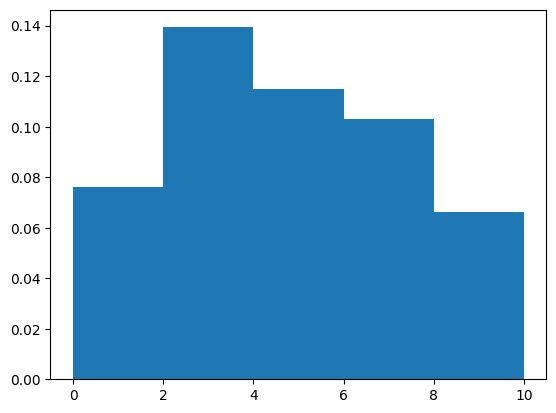

In [5]:
x = np.linspace(0, 10, 6)
p = np.random.rand(6)
print(x)
print(p)

histogram = openmc.stats.Tabular(x=x, p=p, interpolation='histogram')
n_samples = 10_000_000
samples = histogram.sample(n_samples)

h, bins = np.histogram(samples, bins=x)

plt.hist(samples, bins, density=True)
plt.show()

## Multivariate Distributions

It is often difficult to describe spatial or angular distributions as a single multivariate function. As a result, the following classes can be used to define multivariate distributions as a combination of univariate distributions:

Spatially independent distributions:

  - `CartesianIndependent`: indepdendent distributions in x, y, and z
  - `CylindricalIndependent`: independent distributions in cylindrical coordinates (r, z, $\theta$)
  - `SphericalIndependent`: independent distributions in spherical coordinates (r, $\phi$, $\theta$)

Angularly independent distributions:
  - `PolarAzimuthal`: independent distributions in $\phi$ and $\theta$ with respect to a specified reference vector

Example of an independent Cartesian distribution with a line source at $x=1$, $y=4$ from $-1 < z < 1$.

In [6]:
x_dist = openmc.stats.Discrete(x=[1.0], p=[1.0])
y_dist = openmc.stats.Discrete(x=[4.0], p=[1.0])
z_dist = openmc.stats.Uniform(-1.0, 1.0)
line_source = openmc.stats.CartesianIndependent(x=x_dist,
                                                y=y_dist,
                                                z=z_dist)

Other objects in `openmc.stats` are more constrained or "fit-for-purpose". For example, the `openmc.stats.Point` class is designed with point sources in mind. To define a spatial distribution for a point source at $\vec{r} = (10, -20, 30)$:

In [7]:
point = openmc.stats.Point((10, -20, 30))

## Mixed Univariate Distributions

OpenMC allows for combinations of univariate distributions via the `openmc.stats.Mixture` object. This is useful for representing a combination of distributions in the same dimension, as often occurs when modeling emission spectra. Each distribution is sampled with a frequency relative to the others defined by a set of probabilities.

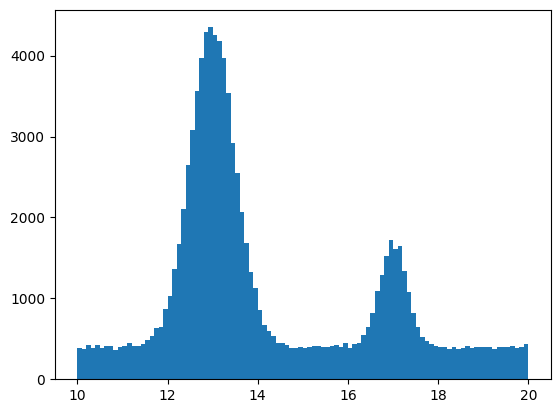

In [8]:
normal1 = openmc.stats.Normal(13, 0.5)
normal2 = openmc.stats.Normal(17, 0.3)
uniform = openmc.stats.Uniform(10.0, 20.0)
mixture = openmc.stats.Mixture([0.5, 0.1, 0.4],
                               [normal1, normal2, uniform])
samples = mixture.sample(100_000)
plt.hist(samples, 100)
plt.show()

# File Sources

The `FileSource` object provides a reference to a file containing particle source sites that OpenMC will read when sourcing particles for transport. These sources are typically generated from the following sources:

  - a fission source from a previous calculation
  - a surface source tally

These files can be in one of two formats:

  - an [OpenMC source file](https://docs.openmc.org/en/stable/io_formats/source.html)
  - a Monte Carlo particle lists ([MCPL](https://mctools.github.io/mcpl/#:~:text=Welcome%20to%20the%20home%20of,various%20Monte%20Carlo%20simulation%20applications.)) file

A strength can be set on this source as well to determine its sampling frequency relative to other sources.

In [9]:
file_source = openmc.FileSource('source.h5', strength=10)

# Compiled Sources

OpenMC defines a function signature, `openmc_create_source(std::string parameters)`, when present in a compiled in a [shared library object](https://en.wikipedia.org/wiki/Shared_library#:~:text=A%20shared%20library%20or%20shared,library's%20executable%20code%20in%20memory.) (most commonly a binary `.so` file), can be called to generate a new source for the simulation. Just as the `FileSource` provides a link to a source file, the `CompiledSource` object provides a link to the library containing the subroutine of interest. 

- A set of parameters to pass to this function can also be set on the object.
- A strength can also be set on this source to determine its sampling frequency relative to other sources in the problem.


```cpp
openmc::Source openmc_create_source(std::string parameters);
```


In [10]:
compiled_source = openmc.CompiledSource('source_library.so',
                                        strength=5)


This source method provides maximal freedom for generation of source sites, but requires knowledge of C/C++ to use. Below is an example implementation of a `RingSource` using a `CompiledSource`:

```cpp
#include <cmath> // for M_PI
#include <memory> // for unique_ptr

#include "openmc/random_lcg.h"
#include "openmc/source.h"
#include "openmc/particle.h"

class RingSource : public openmc::Source
{
  openmc::SourceSite sample(uint64_t* seed) const
  {
    openmc::SourceSite particle;
    // particle type
    particle.particle = openmc::ParticleType::neutron;
    // position
    double angle = 2.0 * M_PI * openmc::prn(seed);
    double radius = 3.0;
    particle.r.x = radius * std::cos(angle);
    particle.r.y = radius * std::sin(angle);
    particle.r.z = 0.0;
    // angle
    particle.u = {1.0, 0.0, 0.0};
    particle.E = 14.08e6;
    return particle;
  }
};

// A function to create a unique pointer to an instance of this class when generated
// via a plugin call using dlopen/dlsym.
// You must have external C linkage here otherwise dlopen will not find the file
extern "C" std::unique_ptr<RingSource> openmc_create_source(std::string parameters)
{
  return std::make_unique<RingSource>();
}
```

# Strength and Weight Normalization

At the end of each batch of particles, OpenMC normalizes tallied results by several factors:

 - the total statistical weight of source particles for that batch
 - the sum of source strengths for all external sources (for fixed source problems)
 - the number of particles executed in the batch

As mentioned above, the `IndependentSource` class sources all particles with a weight of one. The `CompiledSource`, and `FileSource` have no such limitation.